# Predicción del mercado bursatil

Vamos a utilizar el dataset de precios históricos de la acción de Apple (AAPL) descargado de Yahoo Finance. Este dataset contiene información diaria del mercado bursátil, lo que nos permitirá realizar una predicción de series de tiempo.

Usaremos información histórica del mercado bursátil desde el 1 de enero de 2015 hasta el 1 de enero de 2023.

### Este dataset contiene esta información:

1. **Columnas**:
   - **Date**: La fecha correspondiente a cada registro.
   - **Open**: El precio de apertura de la acción en la fecha especificada.
   - **High**: El precio más alto al que se negoció la acción durante la fecha especificada.
   - **Low**: El precio más bajo al que se negoció la acción durante la fecha especificada.
   - **Close**: El precio de cierre de la acción en la fecha especificada. Este es el precio que más se utiliza para los análisis y predicciones.
   - **Adj Close**: El precio de cierre ajustado. Este precio ajusta el precio de cierre de acuerdo a eventos corporativos como dividendos, divisiones de acciones y nuevas emisiones de acciones, proporcionando una visión más precisa del valor real de la acción.
   - **Volume**: El número de acciones negociadas durante la fecha especificada.

### El objetivo es:
**Realizar la predicción del precio de la acción de Apple para el día siguiente con base en la información histórica.**

In [ ]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

## Descargar datos

In [ ]:
# Descargar datos del mercado bursátil de Apple
datos_apple = yf.download('AAPL', start='2015-01-01', end='2023-01-01')

# Visualizar los primeros 10 datos
datos_apple.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714722,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716953,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049515,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973557,237458000
2015-01-09,28.167500,28.312500,27.552500,28.002501,25.000341,214798000
2015-01-12,28.150000,28.157499,27.200001,27.312500,24.384319,198603200
2015-01-13,27.857500,28.200001,27.227501,27.555000,24.600811,268367600
2015-01-14,27.260000,27.622499,27.125000,27.450001,24.507078,195826400


In [ ]:
datos_apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2014 non-null   float64
 1   High       2014 non-null   float64
 2   Low        2014 non-null   float64
 3   Close      2014 non-null   float64
 4   Adj Close  2014 non-null   float64
 5   Volume     2014 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.1 KB


In [ ]:
datos_apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2.014000e+03
mean,72.995713,73.831312,72.182233,73.038039,70.810326,1.317725e+08
std,48.953033,49.604854,48.304993,48.976245,49.100044,6.786645e+07
min,22.500000,22.917500,22.367500,22.584999,20.744019,3.519590e+07
25%,32.328125,32.642502,32.080626,32.348750,29.166336,8.628720e+07
50%,48.039999,48.582500,47.775000,48.165001,45.990993,1.121376e+08
75%,123.727501,125.130001,122.192499,123.697500,121.418718,1.565594e+08
max,182.630005,182.940002,179.119995,182.009995,179.481140,6.488252e+08


## Preparación de los Datos
Para realizar una predicción de series de tiempo, nos enfocaremos en la columna `Close` (precio de cierre), ya que es la que más comúnmente se utiliza para este tipo de análisis.

Necesitamos escalar los datos, y también dividir en entrenamiento, validación y prueba.

In [ ]:
# Preparar los datos
precio_cierre = datos_apple['Close'].values.reshape(-1, 1)

In [ ]:
# Escalar los datos
scaler = StandardScaler()
precio_cierre_escalado = scaler.fit_transform(precio_cierre)

In [ ]:
# Crear conjuntos de entrenamiento 70%, validación 15% y prueba 15%
# NO utilizar train_test_split -> mezcla los datos y NO QUEREMOS ESO

size = len(precio_cierre_escalado)
train_size = int(size * 0.7)
val_size = int(size * 0.15)
test_size = size - train_size - val_size

# Crear conjuntos de entrenamiento, validación y prueba
train_set = precio_cierre_escalado[:train_size]
val_set = precio_cierre_escalado[train_size:train_size+val_size]
test_set = precio_cierre_escalado[train_size+val_size:]

In [ ]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

1409
302
303


Vamos a crear una función que prepare los datos para ser utilizados en un modelo de predicción de series de tiempo.

In [ ]:
def crear_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

### Ejemplo de uso de la función `crear_dataset`
Supongamos que tenemos los siguientes datos de una serie de tiempo:

In [ ]:
data_ejemplo = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])
data_ejemplo

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

Y usamos la función `crear_dataset` con un `time_step` de 3:

In [ ]:
X_ejemplo, y_ejemplo = crear_dataset(data_ejemplo, time_step=3)

El resultado será:

In [ ]:
print('X: \n',X_ejemplo)
print('y: ',y_ejemplo)

X: 
 [[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]]
y:  [4 5 6 7 8 9]


### Explicación del resultado
`X_ejemplo` contiene las secuencias de 3 pasos (ventanas de tiempo) que se utilizan como entradas para el modelo.
`y_ejemplo` contiene el valor siguiente en la serie de tiempo para cada una de estas secuencias.

💡 Consejo:

Pruebe con diferentes valores de `time_step` y observe los resultados para entender mejor la función.

## Vamos a probar con una ventana de tiempo de 5 días

In [ ]:
# Crear dataset con una ventana de tiempo de 5 días
time_step = 5
X_train_, y_train = crear_dataset(train_set, time_step)
X_val_, y_val = crear_dataset(val_set, time_step)

Debemos redimensionar los datos para que sean compatibles con la entrada de LSTM `[samples, time steps, features]`

In [ ]:
X_train = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], 1)
X_val = X_val_.reshape(X_val_.shape[0], X_val_.shape[1], 1)

In [ ]:
X_train[0]

array([[-0.93345028],
       [-0.9491761 ],
       [-0.94912503],
       [-0.94151742],
       [-0.92037948]])

In [ ]:
y_val[0]

0.8551055928192719

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1403, 5, 1)
(1403,)
(296, 5, 1)
(296,)


## Creación del modelo LSTM

In [ ]:
# Probemos con un modelo con 2 capas con 50 celdas LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

### 💡 Aclaración
Vamos a explicar por qué se usa `return_sequences=True` en la primera capa oculta y `return_sequences=False` en la segunda capa oculta.

- **Primera Capa LSTM**:
  - `return_sequences=True` indica que la capa debe devolver la secuencia completa de salidas para cada entrada en la secuencia.
  - Esto significa que si la entrada tiene una forma `(batch_size, time_step, features)`, la salida tendrá la forma `(batch_size, time_step, units)`, donde `units` es el número de unidades LSTM en la capa (en este caso, 50).

  - La primera capa LSTM devuelve la secuencia completa de salidas porque la siguiente capa también es una capa LSTM que necesita recibir la secuencia completa como entrada para procesar la información de la serie de tiempo de manera efectiva.
  - Al devolver toda la secuencia, se preserva la temporalidad y la información a lo largo de la secuencia para la siguiente capa LSTM.

- **Segunda Capa LSTM**:
  - `return_sequences=False` indica que la capa debe devolver solo la última salida en la secuencia.
  - Esto significa que si la entrada tiene una forma `(batch_size, time_step, units)`, la salida tendrá la forma `(batch_size, units)`.

  - La segunda capa LSTM no necesita devolver la secuencia completa porque es la última capa LSTM antes de la capa densa (fully connected layer).
  - Solo la última salida de la segunda capa LSTM es necesaria para hacer la predicción final en la capa densa.
  - Al devolver solo la última salida, se reduce la dimensión de la salida, lo que es adecuado para la capa densa final que produce una única predicción por secuencia de entrada.

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
# Implementamos una parada tempara 'early_stopping' para evitar sobreajuste
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
44/44 [==============================] - 12s 58ms/step - loss: 0.0871 - val_loss: 0.4709
Epoch 2/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.2817
Epoch 3/100
44/44 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.1688
Epoch 4/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.1173
Epoch 5/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 0.0743
Epoch 6/100
44/44 [==============================] - 1s 15ms/step - loss: 9.5394e-04 - val_loss: 0.0529
Epoch 7/100
44/44 [==============================] - 1s 12ms/step - loss: 9.3507e-04 - val_loss: 0.0367
Epoch 8/100
44/44 [==============================] - 0s 11ms/step - loss: 9.2021e-04 - val_loss: 0.0328
Epoch 9/100
44/44 [==============================] - 1s 13ms/step - loss: 9.2456e-04 - val_loss: 0.0281
Epoch 10/100
44/44 [==============================] - 0s 8ms/step - loss: 9.2168e-0

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


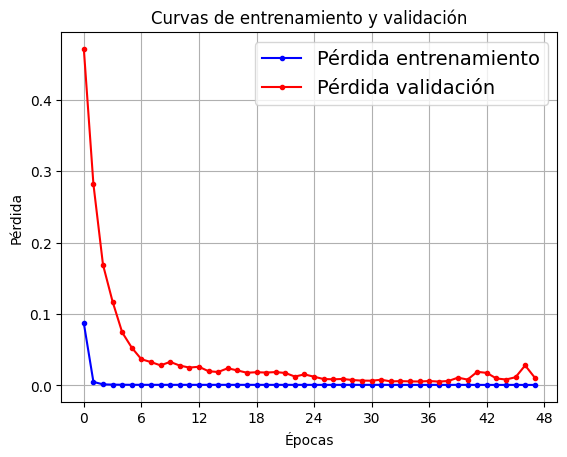

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Pérdida entrenamiento")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Pérdida validación")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title("Curvas de entrenamiento y validación")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Realizamos predicciones en el conjunto de prueba

In [ ]:
# Realizar predicciones

X_test, y_test = crear_dataset(test_set, time_step)
y_pred = model.predict(X_test)

# Invertir la normalización para obtener los valores reales
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 [==============================] - 1s 3ms/step


In [ ]:
# Calcular RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)

Root mean square error:  5.398854563048121
Mean absolute error:  4.284775679360335


Visualicemos los resultados

In [ ]:
# Predicción en el conjunto de entrenamiento para visualización
y_pred_train = model.predict(X_train_)
y_pred_train = scaler.inverse_transform(y_pred_train)

# Predicción en el conjunto de validación para visualización
y_pred_val = model.predict(X_val_)
y_pred_val = scaler.inverse_transform(y_pred_val)

10/10 [==============================] - 0s 3ms/step


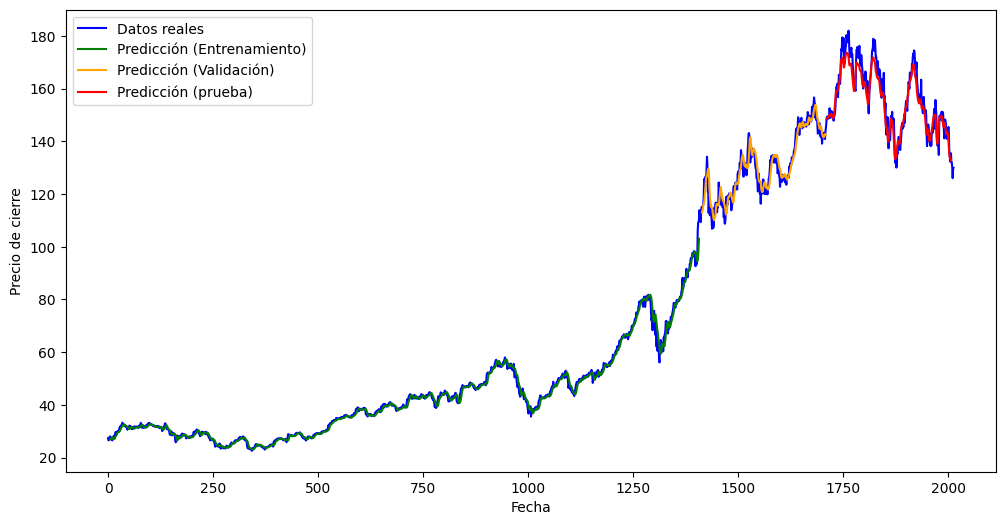

In [ ]:
# Longitud de los datos de entrenamiento y validación
len_train = len(train_set)
len_val = len(val_set)

# Ajustar 'x' para que coincida con la longitud de 'precio_cierre'
x = np.arange(len(precio_cierre))

plt.figure(figsize=(12, 6))
plt.plot(x, precio_cierre, 'b', label='Datos reales')
plt.plot(x[time_step:time_step + len(y_pred_train)], y_pred_train, 'g', label='Predicción (Entrenamiento)')
plt.plot(x[len(train_set) + time_step:len(train_set) + time_step + len(y_pred_val)], y_pred_val, 'orange', label='Predicción (Validación)')
plt.plot(x[len_train + len_val:len_train + len_val + len(y_pred)], y_pred, 'r', label='Predicción (prueba)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()

# 💡 Consejo:
*  Probar con diferentes tamaños en la ventana de entrada.
*  Probar con diferente número de capas ocultas y diferente número de celdas por capa.
*  Hacer predicción en el conjunto de prueba con el mejor modelo y graficar para visualizar los resultados.